<!--NOTEBOOK_HEADER-->
*This notebook contains material from [Controlling Natural Watersheds](https://jckantor.github.io/Controlling-Natural-Watersheds);
content is available [on Github](https://github.com/jckantor/Controlling-Natural-Watersheds.git).*

<!--NAVIGATION-->
< [Water Survey of Canada HYDAT Database](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.01-Water_Survey_of_Canada_HYDAT_Database.ipynb) | [Contents](toc.ipynb) | [Rainy Lake Water Levels](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.03-Rainy_Lake_Water_Levels.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.02-Water_Survey_of_Canada_Usage.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/A.02-Water_Survey_of_Canada_Usage.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Water Survey of Canada Usage

This notebook demonstrates methods for accessing and processing data extracted from the HYDAT database. 

## Initialization

In [39]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Modules to display images and data tables
from IPython.core.display import display
from IPython.core.display import Image

# Module to request http data using Google maps api
import requests

# Module to manipulate dates for historical comparisons
import datetime

import seaborn as sns
sns.set_context('talk')

## Google API Key

A Google API key is required to access Google Map Platform. Consult the "Getting Started with Google Maps Platform" for instructions on how to obtain a key. Once obtained, the key should be added to a single line file file named `google_api_key.txt` located in the data directory.

In [40]:
with open ("../data/google_api_key.txt", "r") as f:
    google_api_key=f.read()

## Read Cached Data Files

Reading the cached data sets.

In [41]:
STATIONS = pd.read_pickle('../data/HYDAT_STATIONS')
LEVELS = pd.read_pickle('../data/HYDAT_LEVELS')
FLOWS = pd.read_pickle('../data/HYDAT_FLOWS')

display(STATIONS['STATION_NAME'])

STATION_NUMBER
05PA001                     KETTLE RIVER ABOVE KETTLE FALLS
05PA003                 NAMAKAN LAKE ABOVE KETTLE FALLS DAM
05PA005                       NORTHERN LIGHT LAKE AT OUTLET
05PA006             NAMAKAN RIVER AT OUTLET OF LAC LA CROIX
05PA007                     CROOKED LAKE NEAR CURTAIN FALLS
05PA010                           FRENCH LAKE NEAR ATIKOKAN
05PA011                     LAC LA CROIX AT CAMPBELL'S CAMP
05PA012                          BASSWOOD RIVER NEAR WINTON
05PA013                     NAMAKAN LAKE AT SQUIRREL ISLAND
05PB001                           SEINE RIVER NEAR LA SEINE
05PB002                 LITTLE TURTLE LAKE NEAR MINE CENTRE
05PB003                 MANITOU RIVER ABOVE DEVIL'S CASCADE
05PB004                 FOOTPRINT RIVER AT RAINY LAKE FALLS
05PB007                        RAINY LAKE NEAR FORT FRANCES
05PB009    SEINE RIVER AT STURGEON FALLS GENERATING STATION
05PB012                 LAC DES MILLE LACS ABOVE OUTLET DAM
05PB014                  

## Mapping WSC Stations in the Rainy River Watershed

The following cell creates a pandas dataframe of monitoring stations from the STATIONS.csv table extracted from the HYDAT database. The extaction searches for all stations with a specified region bounded by latitude and longitudes.

For reference, this is a map of the [Rainy River drainage](http://www.ijc.org/files/tinymce/uploaded/rl_basinmap.pdf) basin available from the International Joint Commission. 

![](../figures/IJC/rl_basinmap_640.png)

The following function maps a list of stations identified by their station numbers. In extracts latitude and longitude from the STATIONS table, then calls the google maps web api to create a map image.

In [151]:
%%writefile mycode/mapStations.py

import pandas as pd
from IPython.core.display import Image
import requests

with open ("../data/google_api_key.txt", "r") as f:
    google_api_key=f.read()
    
STATIONS = pd.read_pickle('../data/HYDAT_STATIONS')
LEVELS = pd.read_pickle('../data/HYDAT_LEVELS')
FLOWS = pd.read_pickle('../data/HYDAT_FLOWS')


def mapStations(stationList, zoom=8):
    """Return a google static map showing the location of flow and level stations.
    
    Globals:
        STATIONS: Pandas dataframe with HYDAT station data.
    
    Args:
        stationList (str): List of station codes.
        zoom (int): zoom level of the resulting map.
        
    Returns:
        Image object containing the static map. Stations are displayed as:
            red: flow station
            green: level station
            yellow: flow and level
        
    """
    locs = ["{0},{1}".format(STATIONS.loc[s,'LATITUDE'], STATIONS.loc[s,'LONGITUDE']) \
             for s in stationList]
    flows = [s for s in stationList if STATIONS.loc[s,'Flow'] == True]
    levels = [s for s in stationList if STATIONS.loc[s,'Level'] == True]
    bSet = set(levels).intersection(set(flows)) 
    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        f"key={google_api_key}" + \
        "&size=640x400" + \
        f"&zoom={zoom}" + \
        "&maptype=terrain" + \
        "&markers=color:red%7Csize:mid%7Clabel:F%7C" + "|".join(["{0},{1}".format(
            STATIONS.loc[s,'LATITUDE'], STATIONS.loc[s,'LONGITUDE']) for s in set(flows).difference(bSet)]) + \
        "&markers=color:green%7Csize:mid%7Clabel:L%7C" +"|".join(["{0},{1}".format(
            STATIONS.loc[s,'LATITUDE'], STATIONS.loc[s,'LONGITUDE']) for s in set(levels).difference(bSet)]) + \
        "&markers=color:yellow%7Csize:mid%7Clabel:B%7C" + "|".join(["{0},{1}".format(
            STATIONS.loc[s,'LATITUDE'], STATIONS.loc[s,'LONGITUDE']) for s in bSet])
    return Image(requests.get(google_maps_url).content)

display(mapStations(STATIONS.index))

Overwriting mycode/mapStations.py


## Viewing Station Data

The HYDAT database is a collection of data associated with monitoring stations located throughout Canada. The STATIONS table contains a list of stations and attributes, including the latitude and longitude of their position. As an example, here we list attributes for 05PB007, a station monitoring the level of Rainy Lake near Fort Frances, Ontario.

In [152]:
display(STATIONS.loc['05PC018'])

STATION_NAME            RAINY RIVER AT MANITOU RAPIDS
PROV_TERR_STATE_LOC                                ON
REGIONAL_OFFICE_ID                                  5
HYD_STATUS                                          A
SED_STATUS                                        NaN
LATITUDE                                      48.6345
LONGITUDE                                    -93.9134
DRAINAGE_AREA_GROSS                             50200
DRAINAGE_AREA_EFFECT                              NaN
RHBN                                                0
REAL_TIME                                           0
CONTRIBUTOR_ID                                    647
OPERATOR_ID                                       600
DATUM_ID                                           10
Level                                            True
Flow                                             True
Name: 05PC018, dtype: object

## Plotting Level Data

Example of plotting lake level data from `HYDAT_LEVELS.csv`.

STATION_NAME            NAMAKAN LAKE ABOVE KETTLE FALLS DAM
PROV_TERR_STATE_LOC                                      ON
REGIONAL_OFFICE_ID                                        5
HYD_STATUS                                                D
SED_STATUS                                              NaN
LATITUDE                                               48.5
LONGITUDE                                          -92.6389
DRAINAGE_AREA_GROSS                                     NaN
DRAINAGE_AREA_EFFECT                                    NaN
RHBN                                                      0
REAL_TIME                                                 0
CONTRIBUTOR_ID                                          647
OPERATOR_ID                                             647
DATUM_ID                                                100
Level                                                  True
Flow                                                       
Name: 05PA003, dtype: object

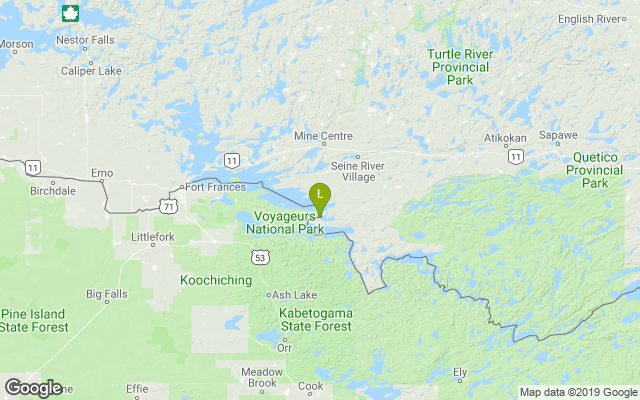

Text(0, 0.5, 'Meters')

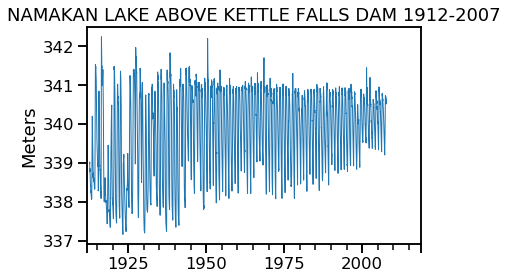

In [153]:
s = '05PA003'
display(STATIONS.loc[s])
display(mapStations([s]))

LEVELS[s].plot(lw=1)
yrA = str(LEVELS[s].dropna().index[0].year)
yrB = str(LEVELS[s].dropna().index[-1].year)
plt.title(STATIONS.loc[s,'STATION_NAME'] + ' ' + yrA + '-' + yrB) 
plt.ylabel('Meters')

## Plotting Flow Data

Example of plotting stream flow data from `WSC_FLOWS.csv`.

STATION_NAME            RAINY RIVER AT FORT FRANCES
PROV_TERR_STATE_LOC                              ON
REGIONAL_OFFICE_ID                                5
HYD_STATUS                                        A
SED_STATUS                                      NaN
LATITUDE                                    48.6085
LONGITUDE                                  -93.4034
DRAINAGE_AREA_GROSS                           38600
DRAINAGE_AREA_EFFECT                            NaN
RHBN                                              0
REAL_TIME                                         0
CONTRIBUTOR_ID                                  647
OPERATOR_ID                                       5
DATUM_ID                                        100
Level                                              
Flow                                           True
Name: 05PC019, dtype: object

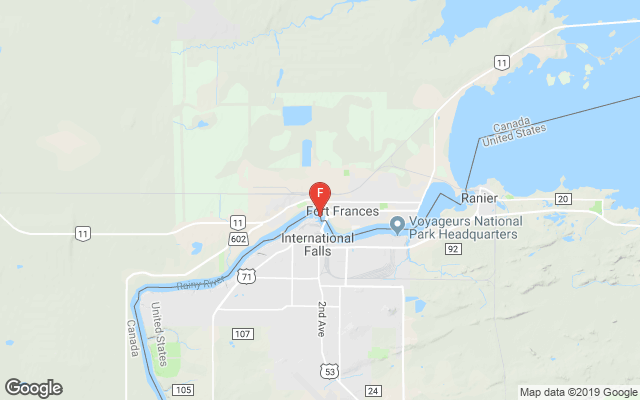

Text(0, 0.5, 'Cubic Meters per Second')

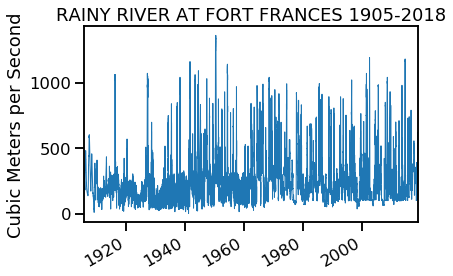

In [154]:
s = '05PC019'
display(STATIONS.loc[s])

display(mapStations([s], 12))
FLOWS[s].dropna().plot(lw=1)
yrA = str(FLOWS[s].dropna().index[0].year)
yrB = str(FLOWS[s].dropna().index[-1].year)
plt.title(STATIONS.loc[s,'STATION_NAME'] + ' ' + yrA + '-' + yrB) 
plt.ylabel('Cubic Meters per Second')

## Example: Comparing Levels on Rainy and Namakan Lakes

Use of this function is demonstrated by reading and plotting the history of lake levels for Rainy and Namakan Lakes.

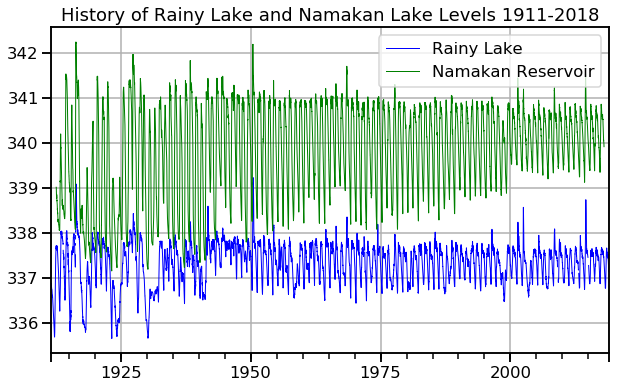

In [155]:
plt.figure(figsize=(10,6))
LEVELS['05PB007'].plot(color='blue',lw=1)   # RL at Fort Frances
LEVELS['05PA003'].plot(color='green',lw=1)  # NL at Kettle Falls
LEVELS['05PA013'].plot(color='green',lw=1)  # NL at Squirrel Island

plt.legend(['Rainy Lake','Namakan Reservoir']);
plt.title('History of Rainy Lake and Namakan Lake Levels ' +
          str(LEVELS['05PB007'].dropna().index[0].year) + 
          '-' + str(LEVELS['05PB007'].dropna().index[-1].year))
plt.grid()

## Example: What was the highest water events on Rainy Lake?

A history of high water events on Rainy Lake.

Text(0.5, 1.0, 'High Water Mark by Year: RAINY LAKE NEAR FORT FRANCES')

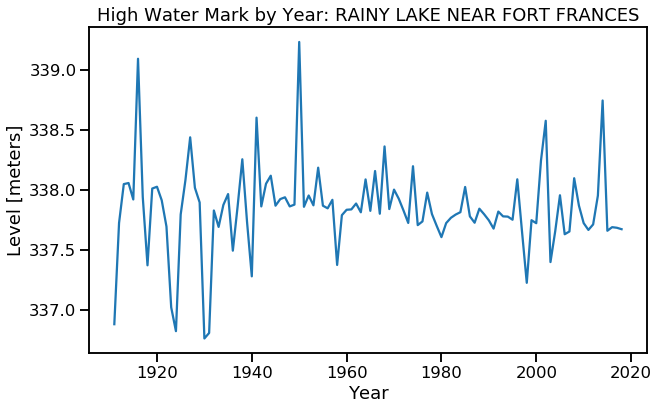

In [156]:
s = '05PB007'

high_levels = np.asarray([[yr,r.max()] for (yr,r) in LEVELS[s].groupby(LEVELS[s].index.year)])
yr,h = high_levels.transpose()

plt.figure(figsize=(10,6))
plt.plot(yr,h)
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('High Water Mark by Year: ' + STATIONS['STATION_NAME'].loc[s])

<!--NAVIGATION-->
< [Water Survey of Canada HYDAT Database](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.01-Water_Survey_of_Canada_HYDAT_Database.ipynb) | [Contents](toc.ipynb) | [Rainy Lake Water Levels](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.03-Rainy_Lake_Water_Levels.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.02-Water_Survey_of_Canada_Usage.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/A.02-Water_Survey_of_Canada_Usage.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>